<a href="https://www.kaggle.com/code/klyushnik/episode-9-fast-start?scriptVersionId=168290301" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e9/sample_submission.csv
/kaggle/input/playground-series-s3e9/train.csv
/kaggle/input/playground-series-s3e9/test.csv
/kaggle/input/predict-concrete-strength/ConcreteStrengthData.csv


# Instal PyCaret

In [2]:
!pip install -U --pre -q pycaret

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pydocstyle 6.2.3 requires importlib-metadata<5.0.0,>=2.0.0; python_version < "3.8", but you have importlib-metadata 6.7.0 which is incompatible.
librosa 0.10.0 requires soundfile>=0.12.1, but you have soundfile 0.11.0 which is incompatible.
ibis-framework 2.1.1 requires importlib-metadata<5,>=4; python_version < "3.8", but you have importlib-metadata 6.7.0 which is incompatible.
flake8 5.0.4 requires importlib-metadata<4.3,>=1.1.0; python_version < "3.8", but you have importlib-metadata 6.7.0 which is incompatible.
cmudict 1.0.13 requires importlib-metadata<6.0.0,>=5.1.0, but you have importlib-metadata 6.7.0 which is incompatible.


# Import regression

In [3]:
import pycaret.regression as py

**Import data**

In [4]:
org = pd.read_csv('/kaggle/input/predict-concrete-strength/ConcreteStrengthData.csv')

In [5]:
train = pd.read_csv('/kaggle/input/playground-series-s3e9/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e9/test.csv')

In [6]:
train = pd.concat([train, org], ignore_index=True)

In [7]:
train = train.drop( train.columns[-1], axis=1)

# Load csv in to PyCaret

In [8]:
import os
import gc
exp_name = py.setup(data = train, 
                    target = 'Strength', 
                    normalize = True
                   )

,Description,Value
0,Session id,7918
1,Target,Strength
2,Target type,Regression
3,Original data shape,"(6437, 10)"
4,Transformed data shape,"(6437, 10)"
5,Transformed train set shape,"(4505, 10)"
6,Transformed test set shape,"(1932, 10)"
7,Numeric features,9
8,Rows with missing values,16.0%
9,Preprocess,True


In [9]:
best = py.compare_models(sort = 'rmse')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,8.9961,143.7840,11.9811,0.4736,0.3707,0.3374,3.2160
gbr,Gradient Boosting Regressor,9.1936,144.5978,12.0165,0.4704,0.3762,0.3515,0.3400
lightgbm,Light Gradient Boosting Machine,9.0297,144.7928,12.0214,0.4701,0.3721,0.3403,0.4570
rf,Random Forest Regressor,9.3480,156.1551,12.4848,0.4283,0.3818,0.3489,0.9050
xgboost,Extreme Gradient Boosting,9.4966,159.3019,12.6109,0.4166,0.3926,0.3559,0.4400
ada,AdaBoost Regressor,10.5063,167.8354,12.9500,0.3839,0.4159,0.4311,0.1420
et,Extra Trees Regressor,9.8291,177.7472,13.3197,0.3490,0.4019,0.3618,0.6110
knn,K Neighbors Regressor,10.9794,205.3894,14.3240,0.2470,0.4537,0.4407,0.0730
br,Bayesian Ridge,11.5025,213.2425,14.5916,0.2195,0.4754,0.4957,0.0460
lar,Least Angle Regression,11.5007,213.2496,14.5919,0.2194,0.4751,0.4952,0.0510


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

**Notice that the sort order of scoring grid is changed now and also the best model returned by this function is selected based on RMSE.**

In [10]:
print(best)

**We can use Optuna**

In [11]:
best_tune = py.tune_model(best,n_iter = 200, search_library = 'optuna', optimize = 'rmse')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,8.6772,136.0975,11.6661,0.4836,0.3573,0.3158
1,9.3252,152.0421,12.3305,0.4807,0.3929,0.3794
2,9.5107,160.9287,12.6858,0.4835,0.3919,0.3740
3,8.7126,123.8813,11.1302,0.5035,0.3556,0.3323
4,9.1387,139.8988,11.8279,0.4485,0.3802,0.3608
5,8.4489,125.8665,11.2190,0.5052,0.3649,0.3273
6,8.6298,133.5597,11.5568,0.4941,0.3377,0.2917
7,9.0220,137.7538,11.7369,0.4722,0.3619,0.3353
8,9.1296,151.3678,12.3032,0.4996,0.3682,0.3244


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

[I 2024-03-22 12:49:21,104] Searching the best hyperparameters using 4505 samples...
[I 2024-03-22 13:22:07,082] Finished hyperparemeter search!


# Try Blend models

**Choose the best**

In [12]:
top3 = py.compare_models(n_select = 3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,8.9961,143.7840,11.9811,0.4736,0.3707,0.3374,0.3960
gbr,Gradient Boosting Regressor,9.1936,144.5978,12.0165,0.4704,0.3762,0.3515,0.3780
lightgbm,Light Gradient Boosting Machine,9.0297,144.7928,12.0214,0.4701,0.3721,0.3403,0.5650
rf,Random Forest Regressor,9.3480,156.1551,12.4848,0.4283,0.3818,0.3489,0.4520
xgboost,Extreme Gradient Boosting,9.4966,159.3019,12.6109,0.4166,0.3926,0.3559,0.3740
ada,AdaBoost Regressor,10.5063,167.8354,12.9500,0.3839,0.4159,0.4311,0.3740
et,Extra Trees Regressor,9.8291,177.7472,13.3197,0.3490,0.4019,0.3618,0.4460
knn,K Neighbors Regressor,10.9794,205.3894,14.3240,0.2470,0.4537,0.4407,0.3650
br,Bayesian Ridge,11.5025,213.2425,14.5916,0.2195,0.4754,0.4957,0.3690
ridge,Ridge Regression,11.5008,213.2491,14.5919,0.2194,0.4751,0.4952,0.3680


Processing:   0%|          | 0/87 [00:00<?, ?it/s]

In [13]:
best_stacker = py.stack_models(top3, meta_model = best_tune) 

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,8.6448,135.5019,11.6405,0.4859,0.3548,0.3158
1,9.3637,153.3972,12.3854,0.4761,0.3942,0.3813
2,9.6292,164.4375,12.8233,0.4722,0.3951,0.3758
3,8.7733,126.5385,11.2489,0.4929,0.3610,0.3375
4,9.0610,139.5998,11.8152,0.4497,0.3807,0.3572
5,8.5284,129.3058,11.3713,0.4917,0.3683,0.3280
6,8.5948,135.3956,11.6360,0.4872,0.3379,0.2883
7,9.1194,142.1089,11.9209,0.4555,0.3622,0.3352
8,9.1111,149.6185,12.2319,0.5054,0.3670,0.3250


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [14]:
#tune_blend_model = py.tune_model(best_blend, n_iter = 50, search_library = 'optuna', optimize = 'rmse')

# Let's some plots

In [15]:
py.evaluate_model(best_tune)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

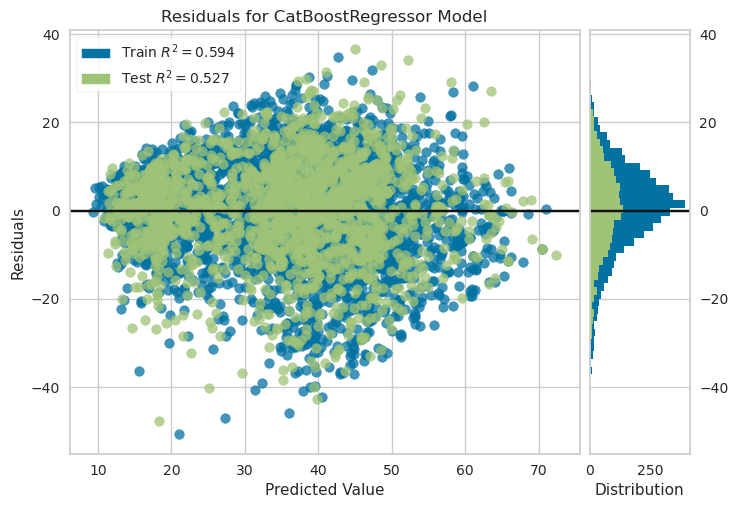

In [16]:
py.plot_model(best_tune, plot = 'residuals')

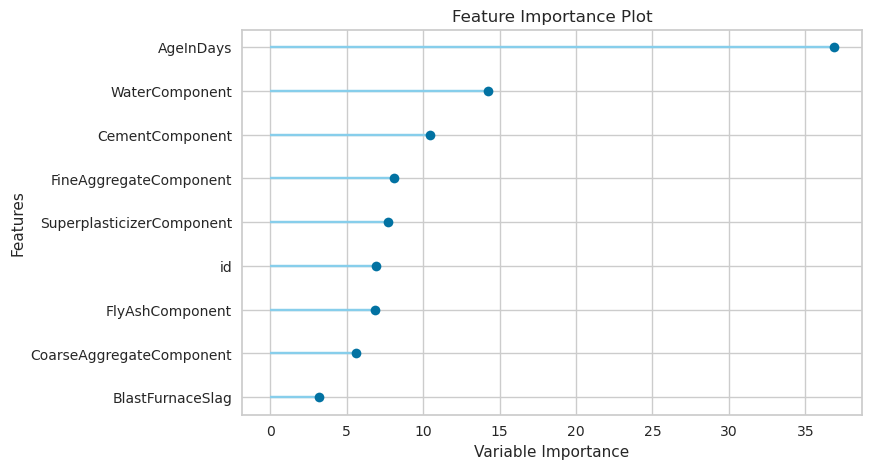

In [17]:
py.plot_model(best_tune, plot = 'feature')

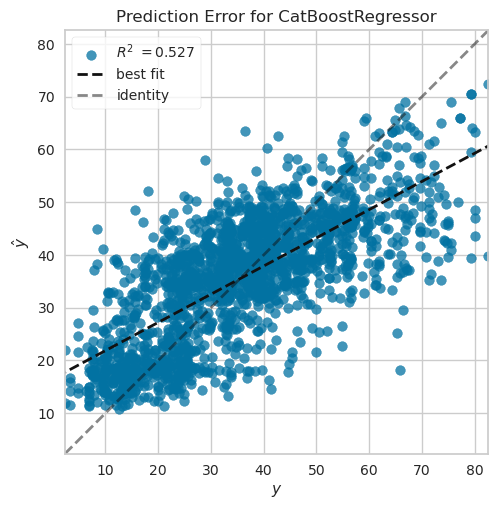

In [18]:
py.plot_model(best_tune, plot = 'error')

# Make predict

In [19]:
predict = py.predict_model(best_stacker, data = test)
predict

,id,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,prediction_label
0,5407,166.100006,75.400002,163.800003,173.800003,4.600000,1007.200012,746.599976,56,53.756399
1,5408,304.000000,0.000000,0.000000,190.000000,0.000000,998.000000,801.000000,7,15.649686
2,5409,225.000000,0.000000,0.000000,185.000000,0.000000,1113.000000,833.000000,28,30.648283
3,5410,251.399994,0.000000,118.300003,188.500000,6.400000,1028.400024,757.700012,100,52.840428
4,5411,144.000000,15.000000,195.000000,176.000000,6.000000,1021.000000,709.000000,28,36.355390
...,...,...,...,...,...,...,...,...,...,...
3600,9007,140.000000,129.000000,100.000000,200.000000,7.000000,864.000000,753.000000,28,36.093818
3601,9008,281.000000,0.000000,0.000000,186.000000,0.000000,1104.000000,774.000000,28,36.242600
3602,9009,289.000000,133.000000,0.000000,194.000000,7.000000,924.000000,760.000000,28,39.951428
3603,9010,469.000000,117.199997,0.000000,137.800003,32.200001,852.099976,840.500000,3,33.723287


In [20]:
sub = pd.read_csv('/kaggle/input/playground-series-s3e9/sample_submission.csv')
sub['Strength'] = predict.prediction_label

In [21]:
sub.to_csv('submission.csv', index=False)